In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [5]:
M = 300 #number of random walkers
R = np.zeros((2*M,3))
for m in range(2*M):
    for d in range(3):
        R[m,d] = np.random.uniform(-0.5, 0.5)    

In [47]:
dt = 0.03 
N = 5000 #Todo: 10000 are equilibration
#todo: change N back to 40000
kappa = 2 
beta = 1/2
alpha = 0.18
E_0 = -2.90338583 #Todo: Is this correct?

In [48]:
def energy_local(vec_r_1, vec_r_2, alpha, beta, kappa):
    r_1 = np.linalg.norm(vec_r_1)
    r_2 = np.linalg.norm(vec_r_2)
    vec_r12 = vec_r_1 - vec_r_2
    r_12 = np.linalg.norm(vec_r12)
    u = 1+alpha*r_12
    scalar_product = np.dot((vec_r_1/r_1) - (vec_r_2/r_2), vec_r12/r_12)
    
    term_1 = (kappa-2)/r_1
    term_2 = (kappa-2)/r_2
    term_3 = (1-2*beta/u**2)/r_12
    term_4 = 2*beta*alpha/u**3
    term_5 = -kappa**2
    term_6 = -(beta**2)/u**4
    term_7 = (kappa*beta/u**2)*scalar_product
    E_L =  term_1 + term_2 + term_3 + term_4 + term_5 + term_6 + term_7    
    return E_L

def psi_T(vec_r_1, vec_r_2, alpha, kappa, beta):
    r_1 = np.linalg.norm(vec_r_1)
    r_2 = np.linalg.norm(vec_r_2)
    vec_r12 = vec_r_1 - vec_r_2
    r_12 = np.linalg.norm(vec_r12)
    pref = beta*r_12/(1+alpha*r_12)
    psi = np.exp(-kappa*r_1)*np.exp(-kappa*r_2)*np.exp(pref)
    return psi

def Fokker_planck(vec_r_1, vec_r_2, alpha, kappa, beta):
    r_1 = np.linalg.norm(vec_r_1)
    #r_2 = np.linalg.norm(vec_r_2)
    vec_r12 = vec_r_2 - vec_r_1
    r_12 = np.linalg.norm(vec_r12)
    u = 1 + alpha*r_12
    factor = beta*(((u/r_12)-alpha)/u**2)
    force_1 = 2*(-kappa*(vec_r_1/r_1)+factor*(vec_r_1-vec_r_2))
    #force_2 = 2*(-kappa*(vec_r_2/r_2)+factor*(vec_r_2-vec_r_1))
    return np.array(force_1)

def greens_function(vec_r_try_1, vec_r_try_2, vec_r_old_1, vec_r_old_2, alpha, beta, kappa, delta_t):    
    f1 = Fokker_planck(vec_r_try_1, vec_r_try_2, alpha, kappa, beta)
    f2 = Fokker_planck(vec_r_old_1, vec_r_old_2, alpha, kappa, beta)
    
    c1 = np.linalg.norm(vec_r_try_1 - vec_r_old_1 - f1*delta_t/2)**2
    c2 = np.linalg.norm(vec_r_try_2 - vec_r_old_2 - f2*delta_t/2)**2
    
    return (1/np.sqrt(2*np.pi*delta_t)) * np.array([np.exp(-c1/(2*delta_t)), np.exp(-c2/2*delta_t)])

def DMC_algorithm(initial_state, num_trials, s, alpha, beta, kappa, n_adjust, delta_t, e_0, disable_tqdm = False):
    sequence_states = [initial_state]
    list_e_t = []
    e_t = e_0
    for step in tqdm(range(num_trials), disable=disable_tqdm):
        if step%n_adjust == 0:
            m_current = sequence_states[-1].shape[0]/2
            e_t = e_0 + np.log(0.5*initial_state.shape[0]/m_current) #todo: Is this correct?
            list_e_t.append(e_t)
        next_sequence = DMC_step(sequence_states[-1], alpha, beta, s, kappa, delta_t, e_t)
        sequence_states.append(next_sequence)
    return sequence_states, np.array(list_e_t)
   
def branching_step(r_accepted, r_2_accepted, delta_t, alpha, beta, kappa, e_t):
    v = energy_local(r_accepted, r_2_accepted, alpha, beta, kappa)
    energy_diff = v - e_t
    q = np.exp(-delta_t*energy_diff)
    rand = np.random.rand()
    if q > 1:
        #walker gives birth
        multiplicity = np.floor(q+rand)
    else:
        if rand < q:
            #walker survives
            multiplicity = 1
        else: 
            #walker dies
            multiplicity = 0
    return int(multiplicity)
   
def DMC_step(current_state, alpha, beta, s, kappa, delta_t, e_t):
    trial_configuration = current_state.copy()
    m_now = int(trial_configuration.shape[0]/2)
    new_state_walker1 = []
    new_state_walker2 = []
    for i in range(m_now):
        which_particle = np.random.choice([0,m_now])
        trial_configuration[i+which_particle] += Fokker_planck(current_state[i+which_particle], current_state[i+m_now-which_particle], alpha, kappa, beta)*delta_t/2
        trial_configuration[i+which_particle] += np.random.uniform(low=-s/2, high=s/2, size=3)*np.sqrt(delta_t)
        p = (psi_T(trial_configuration[i], trial_configuration[i+m_now], alpha, kappa, beta)/psi_T(current_state[i], current_state[i+m_now], alpha, kappa, beta))**2
        g1 = np.prod(greens_function(trial_configuration[i], trial_configuration[i+m_now], current_state[i], current_state[i+m_now], alpha, beta, kappa, delta_t))
        g2 = np.prod(greens_function(current_state[i], current_state[i+m_now], trial_configuration[i], trial_configuration[i+m_now], alpha, beta, kappa, delta_t))
        p *= g1/g2                   
        trial_acceptance_prob = np.min([1, p])
        r_accept = np.random.rand()
        if r_accept < trial_acceptance_prob:
            multiplicity = branching_step(trial_configuration[i], trial_configuration[i+m_now], delta_t, alpha, beta, kappa, e_t)
            for _ in range(multiplicity):
                new_state_walker1.append(trial_configuration[i])
                new_state_walker2.append(trial_configuration[i+m_now])
        else:
            new_state_walker1.append(current_state[i]) #Todo: what happens if change rejected to the walker? Killed? Survives?
            new_state_walker2.append(current_state[i+m_now])
    new_state_walker1 = np.array(new_state_walker1)
    new_state_walker2 = np.array(new_state_walker2)
    new_state = np.concatenate((new_state_walker1, new_state_walker2), axis=0)
    return new_state

In [49]:
sim, energies = DMC_algorithm(R, N, 1, alpha, beta, kappa, 1, dt, E_0)

100%|██████████| 5000/5000 [02:19<00:00, 35.73it/s]


Text(0.5, 0, 'simulation step')

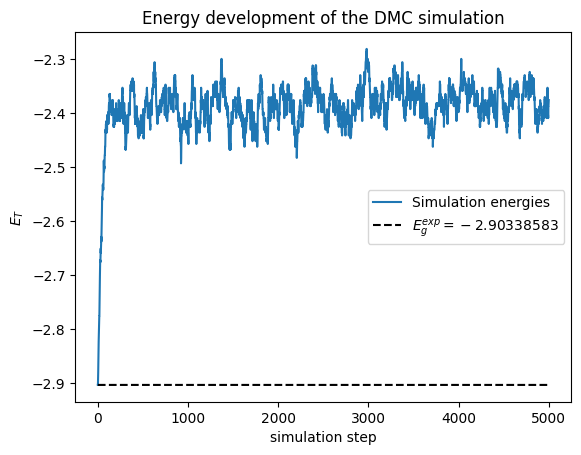

In [56]:
arange_N = np.arange(N)

plt.plot(arange_N, energies, label = "Simulation energies")
plt.plot(arange_N, np.ones(N)*E_0, "k--", label = "$E_{g}^{exp} = −2.90338583$")
plt.title("Energy development of the DMC simulation")
plt.legend()
plt.ylabel("$E_{T}$")
plt.xlabel("simulation step")